## Repositório

[Tópicos Avançados em Inteligência Computacional 2](https://github.com/Manuelfjr/topicos_avancados_ic_ii/tree/develop)

## Atividade 01

**[Avaliação de Algoritmos]**

descrição:

```
Escolha uma base de dados do seu interesse (ver por exemplo repositórios como UCI, OpenML, Kaggle).

Gera uma árvore compacta (por exemplo, com até dois níveis no máximo) para o conjunto de dados do seu interesse. Treine também os outros modelos, como Random Forest, Regressão Logística, Naive Bayes e kNN. Calcule a curva ROC dos modelos para comparar qual modelo foi mais bem sucedido para essa base de exemplos.
```

**[tarefas a serem feitas]**

1. ~~Preparar a base de dados~~ (1.)
2. ~~Holdout~~ (1.3)
3. ~~Treinamento dos modelos~~ (2.1)
4. ~~Obtenção das métricas~~ (2.2)
5. ~~Overview~~ (2.3)
6. ~~Plot da arvore compacta~~ (3.)
7. ~~Curva ROC por modelo~~ (4.)
8. ~~Cross-validation~~ (5.)
9. ~~Conclusões~~ (6.)

## Introdução

informações:

* **dataset**:  Breast cancer wisconsin (diagnostic)

* **Attribute Information**:
    - radius (mean of distances from center to points on the perimeter)

    - texture (standard deviation of gray-scale values)

    - perimeter

    - area

    - smoothness (local variation in radius lengths)

    - compactness (perimeter^2 / area - 1.0)

    - concavity (severity of concave portions of the contour)

    - concave points (number of concave portions of the contour)

    - symmetry

    - fractal dimension (“coastline approximation” - 1)

The mean, standard error, and “worst” or largest (mean of the three worst/largest values) of these features were computed for each image, resulting in 30 features. For instance, field 0 is Mean Radius, field 10 is Radius SE, field 20 is Worst Radius.

* **class**:
    - WDBC-Malignant (1)
    - WDBC-Benign (0)

## Descrição

Durante o decorrer da atividade, será aplicado métodos supervisionados, sendo eles:

* *Decision Tree*;

* *Random Forest*.

* *Regressão Logística*; 

* *Naive Bayes*;

* *kNN*.

## Objetivo

A tarefa a ser realizada para esse conjunto de dados é a aplicação de um conjunto de algoritmos supervisionados, com o intuito de classificar corretamente o tipo do cancer de um individuo, se é Maligno (1) ou Benigno (0). Será treinado um conjunto de algoritmos, utilizando inicialmente o método do holdout, selecionando o melhor modelo, além de exibir inicialmente uma arvore compacta de 2 níveis.


Algumas métricas serão obtidas ao decorrer do experimento, sendo elas:

```py
from sklearn.metrics import confusion_matrix # matriz de confusão para visualização dos outputs
from sklearn.metrics import accuracy_score # acuracia
from sklearn.metrics import precision_score # precisão
from sklearn.metrics import recall_score # recall
from sklearn.metrics import f1_score # f1-score
from sklearn.metrics import roc_auc_score # curva roc
from sklearn.metrics import precision_recall_curve # curva da precisão versus recall
from sklearn.metrics import auc # valor da area sob a curva
```

## Imports

In [100]:
# datasets
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from nb_utils import set_root
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# metrics
from sklearn.metrics import (RocCurveDisplay, accuracy_score, auc,
                             confusion_matrix, f1_score,
                             precision_recall_curve, precision_score,
                             recall_score, roc_auc_score)
# model
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
# utils
from tqdm import tqdm

PROJECT_DIR = set_root(return_path=True)

warnings.filterwarnings('ignore')

## Parameters

In [101]:
target = "label"
content = load_breast_cancer()
features = list(content["feature_names"])

In [102]:
params = {
    "holdout": {
        "test_size": 0.3,
        "random_state": 2024
    }
}

In [103]:
models = {
    "dt": DecisionTreeClassifier(
        max_depth=2,
        min_samples_leaf=30,
        criterion='entropy'
    ),
    "rf": RandomForestClassifier(),
    "lr": LogisticRegression(
        max_iter=1000
    ),
    "nb": GaussianNB(),
    "knn": KNeighborsClassifier(n_neighbors=3)
}

In [104]:
_names = {
    "dt": "DecisionTreeClassifier",
    "rf": "RandomForestClassifier",
    "lr": "LogisticRegression",
    "nb": "NaiveBayes",
    "knn": "KNeighborsClassifier"
}

In [105]:
which_metrics = {
    "Acc": accuracy_score,
    "Prec": precision_score,
    "Rec": recall_score,
    "F1": f1_score,
    "AUC": roc_auc_score
}

## 1. Preparando dataset

### 1.1 Process dataset

In [106]:
data = pd.DataFrame(
    content["data"],
    columns=features
)
data[target] = content["target"]
data.columns = data.columns.str.replace(" ", "_")

### 1.2 Split

In [107]:
X = data.drop(target, axis=1).copy()
y = data[target].values

### 1.3 Holdout

aplicação do processo de holdout, considerando um tamanho de teste de `30%`

In [108]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    **params["holdout"]
)

## 2. Modelagem

### 2.1 Fit

In [109]:
preds = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds[name] = {
        "y_true": y_test,
        "y_pred": model.predict(X_test)
    }

### 2.2 Metrics

In [110]:
metrics = pd.DataFrame(index=preds.keys(), columns=which_metrics.keys())
for m, metric in which_metrics.items():
    for name, model in models.items():
        if m == "Acc":
            metrics.loc[name, m] = float(metric(**preds[name]))
        elif (m != "Acc") and (m != "AUPR") and (m != "AUC"):
            metrics.loc[name, m] = float(metric(**preds[name], pos_label=1))
        elif m == "AUC":
            metrics.loc[name, m] = float(
                roc_auc_score(
                    preds[name]["y_true"],
                    model.predict_proba(X_test)[:, 1]
                )
            )
        elif m == "AUPR":
            precision, recall, thresholds = precision_recall_curve(
                preds[name]["y_true"],
                model.predict_proba(X_test)[:, 1],
                pos_label='yes'
            )
            metrics.loc[name, m] = float(auc(recall, precision))
    metrics[m] = metrics[m].astype(float)

### 2.3 Overview

In [111]:
metrics.index = metrics.reset_index()["index"].replace(_names).values

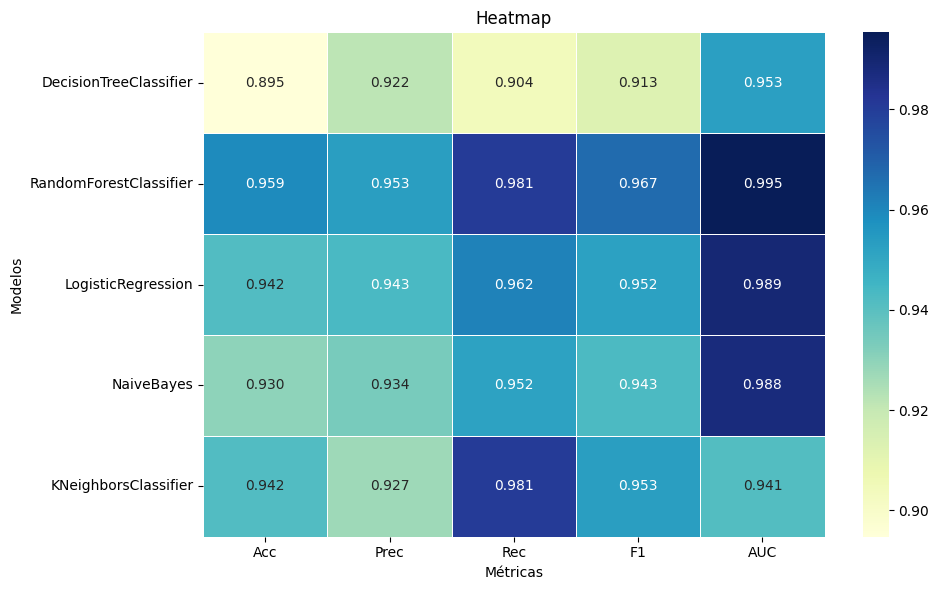

In [112]:
fig_hm, axes_hm = plt.subplots(1, 1, figsize=(10, 6))
sns.heatmap(metrics, annot=True, cmap='YlGnBu', fmt=".3f", linewidths=.5, ax=axes_hm)
axes_hm.set_title('Heatmap')
axes_hm.set_xlabel('Métricas')
axes_hm.set_ylabel('Modelos')
plt.tight_layout()
plt.show()

Podemos notar que o modelo *Random Forest Classifier* apresentou, em geral, melhores métricas, com exceção do recall, aonde o *KNN* se destacou com um valor de `0.981`.

## 2.4 Matriz de confusão

In [113]:
n_col = 2
if len(models.keys()) % 2 == 0:
    n_row = len(models.keys()) // n_col
else:
    n_row = (len(models.keys()) // n_col) + 1

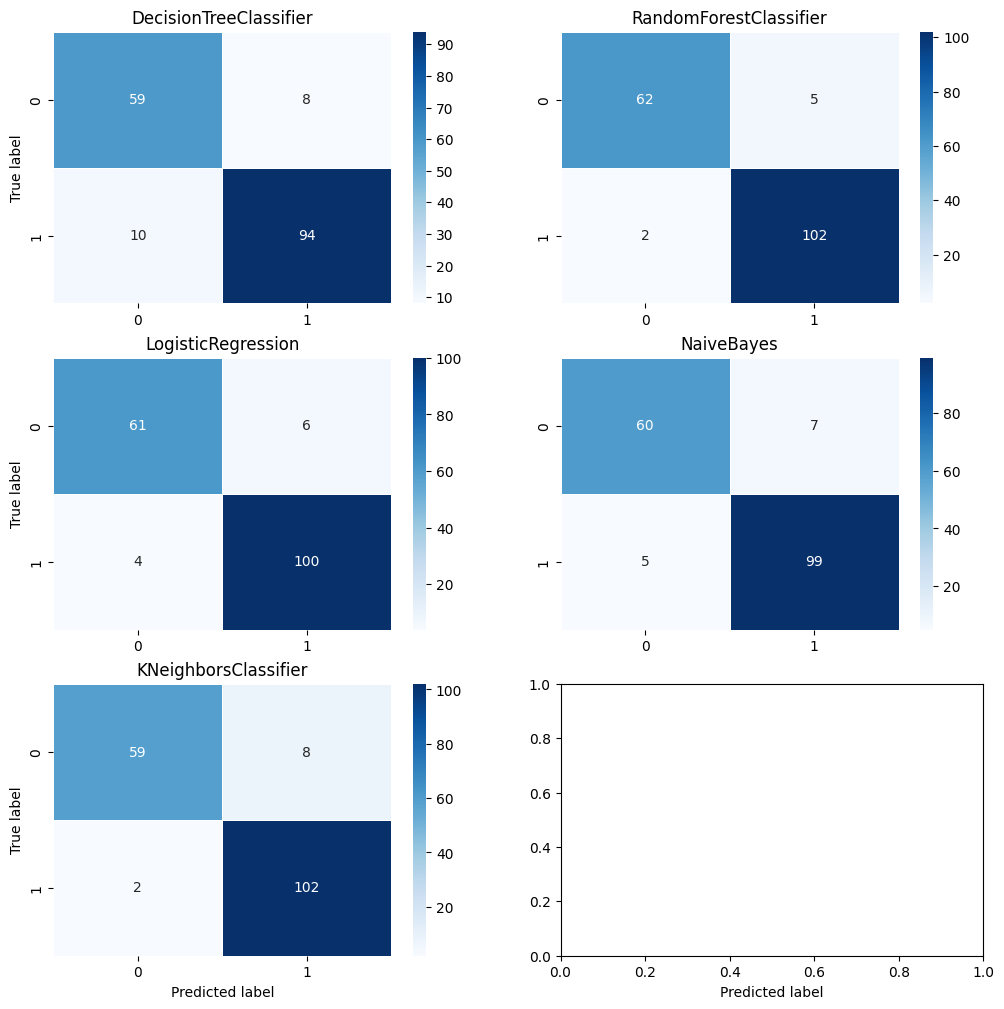

<Figure size 640x480 with 0 Axes>

In [114]:
fig_cm, axes = plt.subplots(n_row, n_col, figsize=(12, 12))

axes = axes.flatten()
for idx, ((name, model), ax) in enumerate(zip(models.items(), axes)):
    cm = confusion_matrix(y_test, preds[name]["y_pred"], labels=models[name].classes_)

    sns.heatmap(
        cm,
        annot=True,
        cmap="Blues",
        fmt="d",
        linewidths=.5,
        ax=ax
    )
    ax.set_title(name.replace(name, _names[name]))
    if idx == len(models.items()) - 1:
        ax.set_xlabel('Predicted label')
        if len(models.items()) % 2 != 0:
            axes[-1].set_xlabel('Predicted label')
    if idx % 2 == 0:
        ax.set_ylabel('True label')
    plt.close()
plt.tight_layout()
fig_cm

Ao olharmos apenas para a classe positiva, o modelo que mais se destacou foi o *KNN* contudo apresentou maiores valores de falso positivo. Em termos gerais e quanto a balanceamento geral das classificações, o modelo *Random Forest* se destacou novamente ao olharmos diretamente para a matriz de confusão.

## 3. Arvore compacta

Como os modelos ja foram treinados, podemos obter a arvore compacta mais facilmente.

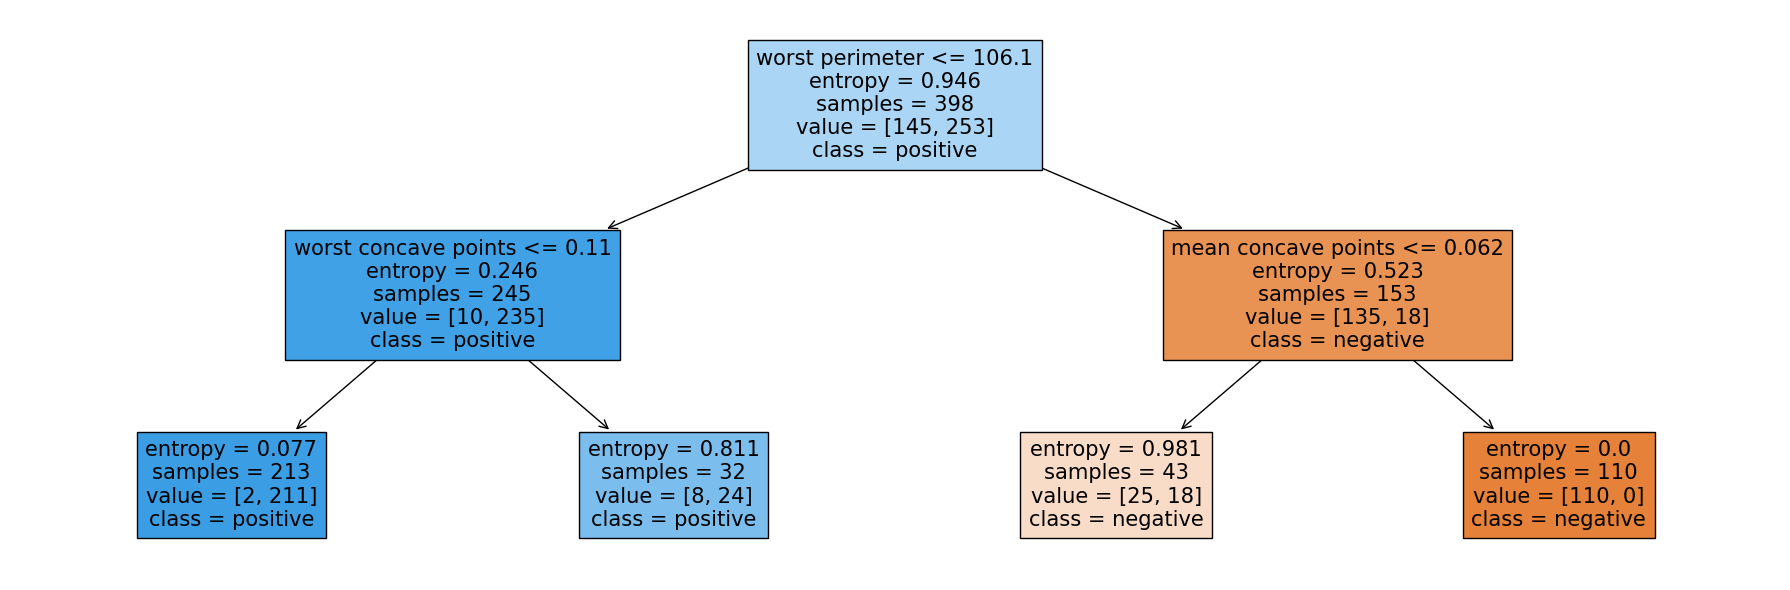

In [115]:
fig_dt, axes = plt.subplots(1, 1, figsize=(18, 6))
plot_tree(
    models["dt"],
    feature_names=features,
    class_names=['negative', "positive"],
    filled=True,
    ax=axes
)
plt.tight_layout()
plt.show()

Ao olharmos a arvore compacta, podemos notar que a variável *Worst Perimeter é bem impactante na hora de separação entre as classes positivas das negativas. Em segundo nivel, podemos notar que a variavel *Worst Concave Points*, ao olhar para a classe positiva, é possivel notalr um baixo grau de entropia, conseguindo ser usada de forma significante para separar a classe das demais.

## 4. Curva ROC

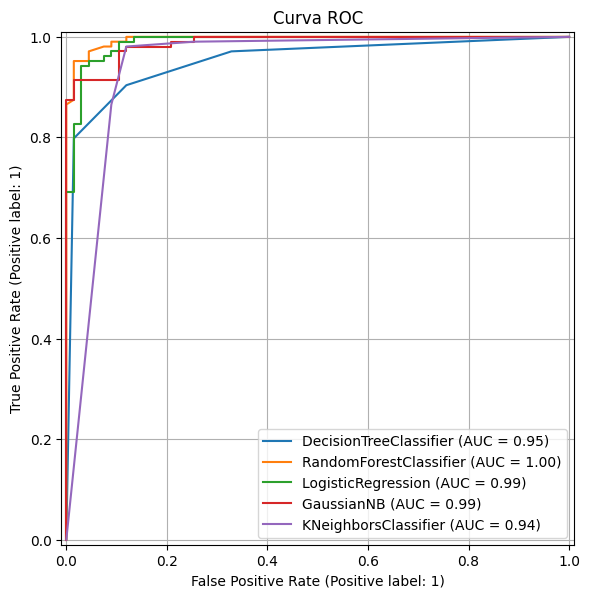

In [116]:
fig_roc, axes = plt.subplots(1, 1, figsize=(6, 8))
plt.tight_layout()
for name, model in models.items():
    RocCurveDisplay.from_estimator(model, X=X_test, y=y_test, ax=axes)
axes.grid()
axes.set_title("Curva ROC")
plt.tight_layout()
plt.show()

## 5. Cross-validation

In [117]:
num_folds = 10
cv_scores = {}
for name, model in tqdm(models.items()):
    cv_scores[name] = {}
    for i in ["accuracy", "recall", "precision", "f1", "roc_auc"]:
        scores = cross_val_score(model, X, y, cv=num_folds, scoring=i)
        cv_scores[name][i] = scores.mean()

100%|██████████| 5/5 [00:25<00:00,  5.02s/it]


In [118]:
cv_results = pd.DataFrame(cv_scores)
cv_results.rename(columns=_names)

,DecisionTreeClassifier,RandomForestClassifier,LogisticRegression,NaiveBayes,KNeighborsClassifier
accuracy,0.892857,0.961372,0.950815,0.936779,0.926190
recall,0.927302,0.977381,0.972143,0.966270,0.958016
precision,0.911139,0.965407,0.952119,0.935949,0.928438
f1,0.915994,0.966614,0.961436,0.950494,0.942189
roc_auc,0.964782,0.991136,0.993387,0.988441,0.950248


## 6. Conclusões

|                    | **DecisionTreeClassifier** | **RandomForestClassifier** | **LogisticRegression** | **NaiveBayes** | **KNeighborsClassifier** |
|--------------------|------------------------|-------------------------|--------------------|------------|----------------------|
| **accuracy**           |         0.892857       |         0.963127        |      0.950815      |  0.936779  |       0.926190       |
| **recall**             |         0.927302       |         0.980317        |      0.972143      |  0.966270  |       0.958016       |
| **precision**          |         0.911139       |         0.965268        |      0.952119      |  0.935949  |       0.928438       |
| **f1**                 |         0.915994       |         0.974951        |      0.961436      |  0.950494  |       0.942189       |
| **roc_auc**            |         0.963724       |         0.991792        |      0.993387      |  0.988441  |       0.950248       |


Por fim, ao analisarmos apenas a área sob a *Curva ROC* (4.), podemos notar que existe um empate entre os modelos *Random Forest, Logistic Regression* e *GaussianNB (Naive Bayes considerando a verossimilhanca seguindo uma Gaussiana)*, empate técnico quando olhamos o gráfico acima, mas ao olharmos a seção (2.3) do material, é possivel notar o destaque do *Random Forest*.

Ao compararmos as métricas anteriores, o modelo mais balanceado em termos gerais das métricas, é o *Random Forest*, lembrando o *heatmap* da seção (2.3), o modelo desempenhou superiormente com respeito as outras métricas, ainda que em geral, os modelos desempenharam de forma bem semelhante para o cenário do conjunto de dados *Breast Cancer*.

Por fim, ao olharmos para os resultados apos a validação cruzada, considerando um numero de folds de 10, podemos notar que o em termos de generalização, o modelo Random Forest apresentou os melhores resultados.